# Implementando uma GRU com Grid Search para escolher melhor os parâmetros no Sistema de Lorenz

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

import sys 
sys.path.insert(0, '../../../scripts')

### 1.2 Bibliotecas para GRU

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit # para gridsearch com holdout

# o holdout são os últimos valores do vetor de dados de treino
# a cada divisão do timeseriessplit, o conjunto de treino incorpora mais dados do conjunto de teste

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
import gru_model as gru

### 1.3 Bibliotecas dos sistemas caóticos

In [6]:
import timeseries as times
import lorenzsystem as lsys

## 2. Gerando a série temporal do sistema de Lorenz

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original.

In [7]:
t_inicial = 0
t_final = 50
dt = 0.01

In [8]:
estado_inicial = np.array([0.1, 0, 0])

In [9]:
sis_lorenz = lsys.SistemaLorenz(estado_inicial, dt=dt)

In [10]:
solucoes, instantes_temporais = sis_lorenz.calcular(t_inicial = t_inicial, t_final = t_final)

In [11]:
x = solucoes[:, 0]
y = solucoes[:, 1]
z = solucoes[:, 2]

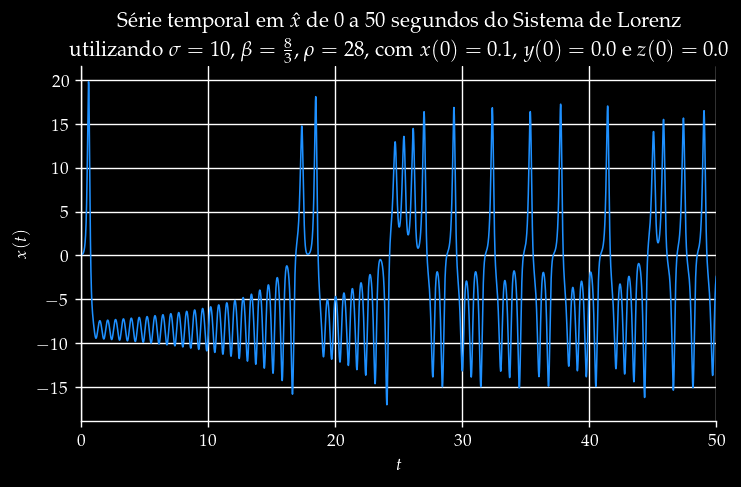

In [12]:
fig, ax = plt.subplots()
ax.set_title("Série temporal em $\hat{x}$ de 0 a 50 segundos do Sistema de Lorenz\n utilizando $\sigma = 10$, " + r"$\beta =\frac{8}{3}$, " + r"$\rho=28$, com " + "$x(0) =$ " + str(estado_inicial[0]) + ", $y(0) = $ " + str(estado_inicial[1]) + " e $z(0) =$ " + str(estado_inicial[2]))
ax.plot(instantes_temporais, x, color='DodgerBlue', linewidth=0.9)

ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(0,50)
ax.grid(True)

fig.tight_layout()
sns.despine()
plt.show()

### Ajustando a escala

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler(feature_range=(-1,1))
x = scaler.fit_transform(x.reshape(-1,1)).reshape(len(solucoes[:, 0]), )

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [15]:
K = 4
L = 3
tam_teste = 0.15

In [16]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [17]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

### 2.2 Pré-processamento nos dados de entrada

In [18]:
len_treino = X_treino.shape[0]
len_teste = X_teste.shape[0]
n_samples = X_treino.shape[1]

In [19]:
X_treino = np.reshape(X_treino,(len_treino, n_samples, 1))
X_teste = np.reshape(X_teste,(len_teste, n_samples, 1))

## 3. Definindo o modelo para a GRU e executando os Gridsearches

In [20]:
holdout = TimeSeriesSplit(n_splits=4, test_size=int(0.1*len(y_treino)), gap=0)

### 3.1 Criando o objeto da GRU

In [21]:
gru_gridsearch = gru.ModeloGRU(input_shape = (K, 1))

Utilizaremos os seguintes parâmetros no *Grid Search*:

In [22]:
param_grid = dict(batch_size=[2, 4, 8, 16, 32], 
                  init_mode = ['glorot_normal', 'glorot_uniform'],
                  n_units = [5, 10, 15, 20, 30, 50, 75, 100],
                  learning_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

Para facilitar, dividiremos esse processo em etapas.

### 3.2 Definindo parâmetros que não serão definidos pelo *Grid Search*

In [23]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

### 3.3 Definindo e executando o primeiro *Grid Search*

Primeiro, avaliaremos o impacto do *batch size*.

In [24]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32])

In [25]:
model_cv_1 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0)

In [26]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [27]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END .......................................batch_size=2; total time= 2.6min
[CV] END .......................................batch_size=2; total time= 3.0min
[CV] END .......................................batch_size=2; total time= 3.4min
[CV] END .......................................batch_size=2; total time= 3.8min
[CV] END .......................................batch_size=4; total time= 1.3min
[CV] END .......................................batch_size=4; total time= 1.5min
[CV] END .......................................batch_size=4; total time= 1.7min
[CV] END .......................................batch_size=4; total time= 1.9min
[CV] END .......................................batch_size=8; total time=  44.6s
[CV] END .......................................batch_size=8; total time=  52.1s
[CV] END .......................................batch_size=8; total time= 1.0min
[CV] END .......................................b

In [28]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000022 using {'batch_size': 8}


In [29]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000048 (0.000045) with: {'batch_size': 2}
-0.000056 (0.000035) with: {'batch_size': 4}
-0.000022 (0.000018) with: {'batch_size': 8}
-0.000041 (0.000022) with: {'batch_size': 16}
-0.000045 (0.000028) with: {'batch_size': 32}


### 3.4 Definindo e executando o segundo *Grid Search*

Agora, avaliaremos o impacto do *learning rate* do otimizador.

In [30]:
model_cv_2 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0, batch_size=8)

In [31]:
param_grid_2 = dict(learning_rate=[0.001, 0.003, 0.005, 0.008, 0.01])

In [32]:
grid = GridSearchCV(estimator=model_cv_2, param_grid=param_grid_2, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [33]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END ................................learning_rate=0.001; total time=  45.0s
[CV] END ................................learning_rate=0.001; total time=  51.9s
[CV] END ................................learning_rate=0.001; total time=  59.0s
[CV] END ................................learning_rate=0.001; total time= 1.1min
[CV] END ................................learning_rate=0.003; total time=  44.8s
[CV] END ................................learning_rate=0.003; total time=  52.3s
[CV] END ................................learning_rate=0.003; total time=  59.3s
[CV] END ................................learning_rate=0.003; total time= 1.1min
[CV] END ................................learning_rate=0.005; total time=  44.7s
[CV] END ................................learning_rate=0.005; total time=  51.8s
[CV] END ................................learning_rate=0.005; total time=  59.7s
[CV] END ................................learning

In [34]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000017 using {'learning_rate': 0.001}


In [35]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000017 (0.000004) with: {'learning_rate': 0.001}
-0.000027 (0.000013) with: {'learning_rate': 0.003}
-0.000033 (0.000014) with: {'learning_rate': 0.005}
-0.000033 (0.000012) with: {'learning_rate': 0.008}
-0.000023 (0.000008) with: {'learning_rate': 0.01}


### 3.5 Definindo e executando o terceiro *Grid Search*

Agora, avaliaremos o impacto do inicializador da camada intermediária, considerando a $\tanh$ como função de ativação.

In [36]:
model_cv_3 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0, batch_size=8, learning_rate=0.001)

In [37]:
param_grid_3 = dict(init_mode = ['glorot_uniform', 'glorot_normal'])

In [38]:
grid = GridSearchCV(estimator=model_cv_3, param_grid=param_grid_3, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [39]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] END ...........................init_mode=glorot_uniform; total time=  45.2s
[CV] END ...........................init_mode=glorot_uniform; total time=  52.2s
[CV] END ...........................init_mode=glorot_uniform; total time=  59.3s
[CV] END ...........................init_mode=glorot_uniform; total time= 1.1min
[CV] END ............................init_mode=glorot_normal; total time=  44.7s
[CV] END ............................init_mode=glorot_normal; total time=  52.2s
[CV] END ............................init_mode=glorot_normal; total time=  59.2s
[CV] END ............................init_mode=glorot_normal; total time= 1.1min


In [40]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000025 using {'init_mode': 'glorot_uniform'}


In [41]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000025 (0.000017) with: {'init_mode': 'glorot_uniform'}
-0.000030 (0.000011) with: {'init_mode': 'glorot_normal'}


### 3.6 Definindo e executando o quarto *Grid Search*

Agora, avaliaremos o número de unidades *GRU* na camada intermediária.

In [42]:
model_cv_4 = KerasRegressor(build_fn=gru_gridsearch.gridsearch, epochs=100, verbose=0, batch_size=8, learning_rate=0.001, init_mode='glorot_uniform')

In [43]:
param_grid_4 = dict(n_units = [5, 10, 15, 20, 30, 50, 75, 100])

In [44]:
grid = GridSearchCV(estimator=model_cv_4, param_grid=param_grid_4, n_jobs=1, cv=holdout, scoring='neg_mean_squared_error', verbose=2)

In [45]:
grid_result = grid.fit(X_treino, y_treino)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ..........................................n_units=5; total time=  45.5s
[CV] END ..........................................n_units=5; total time=  53.1s
[CV] END ..........................................n_units=5; total time= 1.0min
[CV] END ..........................................n_units=5; total time= 1.1min
[CV] END .........................................n_units=10; total time=  45.6s
[CV] END .........................................n_units=10; total time=  52.5s
[CV] END .........................................n_units=10; total time= 1.0min
[CV] END .........................................n_units=10; total time= 1.1min
[CV] END .........................................n_units=15; total time=  45.3s
[CV] END .........................................n_units=15; total time=  52.6s
[CV] END .........................................n_units=15; total time= 1.0min
[CV] END ........................................

In [46]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.000018 using {'n_units': 30}


In [47]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.000022 (0.000010) with: {'n_units': 5}
-0.000040 (0.000021) with: {'n_units': 10}
-0.000028 (0.000017) with: {'n_units': 15}
-0.000036 (0.000026) with: {'n_units': 20}
-0.000018 (0.000007) with: {'n_units': 30}
-0.000035 (0.000012) with: {'n_units': 50}
-0.000031 (0.000012) with: {'n_units': 75}
-0.000026 (0.000002) with: {'n_units': 100}


### Treino com o melhor modelo

#### Dados de entrada

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
x = solucoes[:, 0]
scaler = MinMaxScaler(feature_range=(-1,1))
x = scaler.fit_transform(x.reshape(-1,1)).reshape(len(solucoes[:, 0]), )

In [16]:
K = 4
L = 3
tam_teste = 0.15

In [17]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [18]:
X_treino, X_teste, X_val, y_treino, y_teste, y_val = serie_temporal.dividir_treino_teste_validacao(tam_teste=0.15, tam_val=0.1)

#### Ajuste no modelo

In [19]:
model = gru.ModeloGRU(input_shape = (K, 1), name='GRU-logistic')

In [20]:
model.criar_modelo(n_units=30, init_mode='glorot_uniform')

In [21]:
model.montar(learning_rate=0.001)

In [22]:
model.visualizar()

Model: "GRU-logistic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_gru (GRU)             (None, 30)                2970      
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 31        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.treinar(X_treino, X_val, y_treino, y_val, batch_size=8)

Epoch 1/100
478/478 [==============================] - 3s 3ms/step - loss: 0.0417 - val_loss: 0.0090
Epoch 2/100
478/478 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 3/100
478/478 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 4/100
478/478 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 5/100
478/478 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 5.2228e-04
Epoch 6/100
478/478 [==============================] - 1s 2ms/step - loss: 3.5978e-04 - val_loss: 1.5245e-04
Epoch 7/100
478/478 [==============================] - 1s 2ms/step - loss: 1.2620e-04 - val_loss: 6.8360e-05
Epoch 8/100
478/478 [==============================] - 1s 2ms/step - loss: 7.5660e-05 - val_loss: 2.7130e-05
Epoch 9/100
478/478 [==============================] - 1s 2ms/step - loss: 8.6284e-05 - val_loss: 5.5815e-05
Epoch 10/100
478/478 [==============================] -

## Teste com o melhor modelo

In [24]:
y_pred = model.predicao(X_teste, scaler=scaler)

### Desfazendo o *MinMaxScaler*

In [25]:
y_teste = scaler.inverse_transform(y_teste)

### Gráfico

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


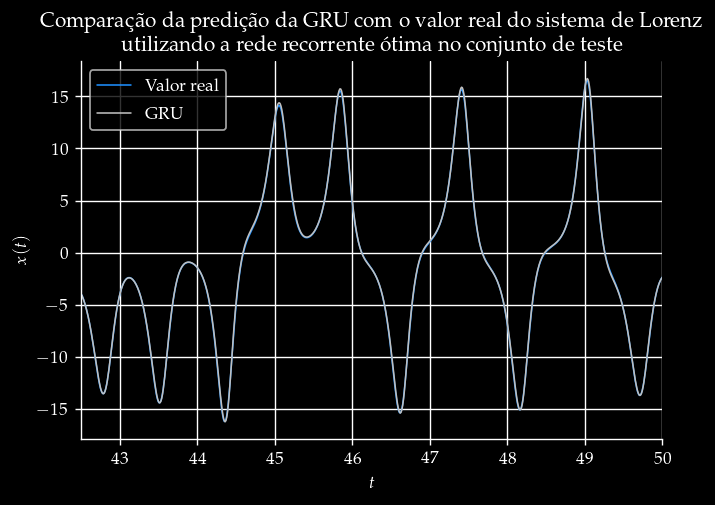

In [26]:
fig, ax = plt.subplots()
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste):,], y_teste, color='DodgerBlue', label='Valor real', linewidth=0.9)
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste):,], y_pred, color='Silver', label='GRU', linewidth=0.9)

ax.set_title("Comparação da predição da GRU com o valor real do sistema de Lorenz\n utilizando a rede recorrente ótima no conjunto de teste")
ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(42.5, 50)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()
fig.savefig("../../../images/gru/performance/gru-vs-lorenz.png")

### Erro Quadrático Médio

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
mse = mean_squared_error(y_teste, y_pred)
print("MSE = " + str(mse))

MSE = 0.013211941712343881


### Salvando o Modelo

In [29]:
model.salvar("../../../models/gru/gru-lorenz", h5="ON")

O modelo foi salvo!
